<a href="https://colab.research.google.com/github/eridona03/CVexercises/blob/main/Exercise4Eridona.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##1. Generate synthetic image with random blobs

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Image loaded successfully with shape: (3043, 2248, 3)


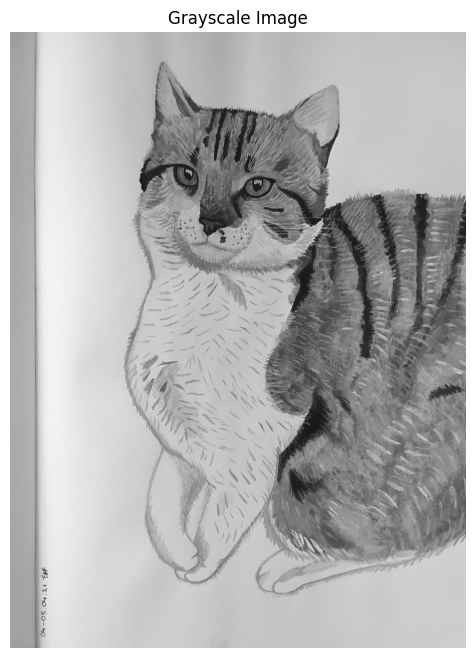

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, filters, measure, feature, color, draw
import random
from google.colab import drive


drive.mount('/content/drive')
image_path = '/content/drive/My Drive/cat.jpg'

try:

    img = io.imread(image_path)
    print(f"Image loaded successfully with shape: {img.shape}")

    # Convert to grayscale if it's a color image
    if len(img.shape) > 2:
        if img.shape[2] == 4:  # Handle RGBA images
            rgb_img = img[:,:,:3]
            img_gray = color.rgb2gray(rgb_img)
        else:
            img_gray = color.rgb2gray(img)
    else:
        img_gray = img

    # Ensure proper data type and range
    img_gray = img_gray.astype(float)
    if img_gray.max() > 1.0:
        img_gray = img_gray / 255.0

except Exception as e:
    print(f"Error loading image: {e}")
    print("Generating synthetic blob image instead...")

    img_size = (512, 512)
    img_gray = np.zeros(img_size, dtype=float)

    # Generate random blobs
    for _ in range(20):
        center_y = random.randint(50, img_size[0]-50)
        center_x = random.randint(50, img_size[1]-50)
        radius = random.randint(10, 50)
        rr, cc = draw.disk((center_y, center_x), radius)
        valid_indices = (rr >= 0) & (rr < img_size[0]) & (cc >= 0) & (cc < img_size[1])
        rr, cc = rr[valid_indices], cc[valid_indices]
        img_gray[rr, cc] = 1.0

    print("Synthetic image with random blobs generated.")

plt.figure(figsize=(8, 8))
plt.imshow(img_gray, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')
plt.show()

##2. Object segmentation and labeling
* Segmentation of blobs using Otsu's optimal threshold
* Labeling connected regions
* Visualization

Number of blobs detected: 5078


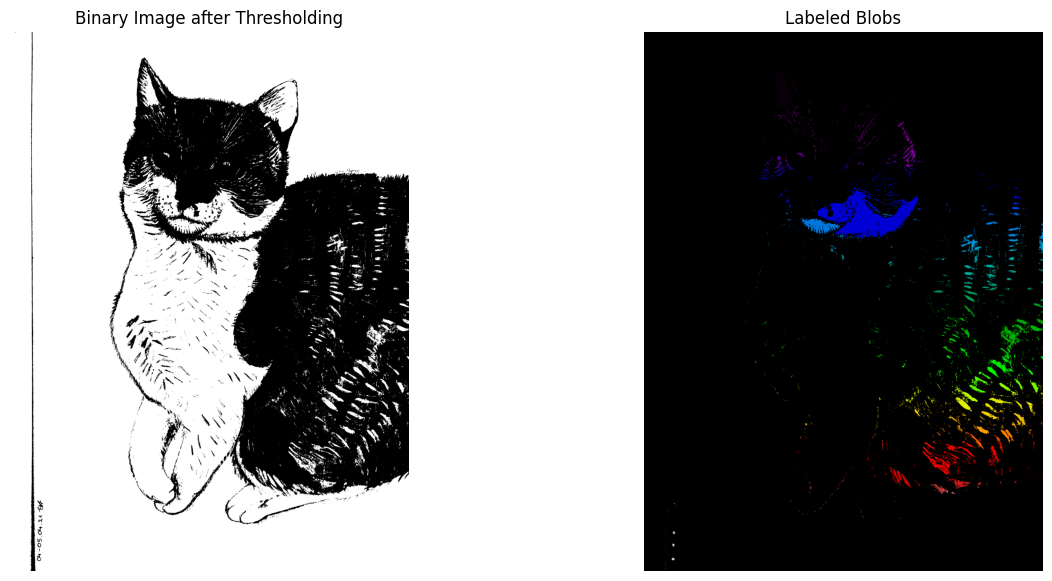

In [59]:
from skimage import io, filters, measure, color

# Apply Otsu's thresholding
thresh = filters.threshold_otsu(img_gray)
binary = img_gray > thresh

# Label connected regions
labeled_img = measure.label(binary)
num_blobs = labeled_img.max()
print(f"Number of blobs detected: {num_blobs}")

# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
axes[0].imshow(binary, cmap='gray')
axes[0].set_title('Binary Image after Thresholding')
axes[0].axis('off')

axes[1].imshow(labeled_img, cmap='nipy_spectral')
axes[1].set_title('Labeled Blobs')
axes[1].axis('off')
plt.show()

##3. Get regional properties in a pandas dataframe
Function documentation with a list of available attributes can be found at https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops_table

Represent area of the blobs as a function of the major axis length

Regional properties of the blobs:
   label       area  eccentricity    extent  major_axis_length
0      1   371043.0      0.999190  0.975466        3502.316416
1      2  4161190.0      0.797439  0.643209        3944.145774
2      3        4.0      0.790569  0.666667           2.828427
3      4        3.0      0.816497  0.750000           2.309401
4      5       92.0      0.899221  0.393162          19.929357


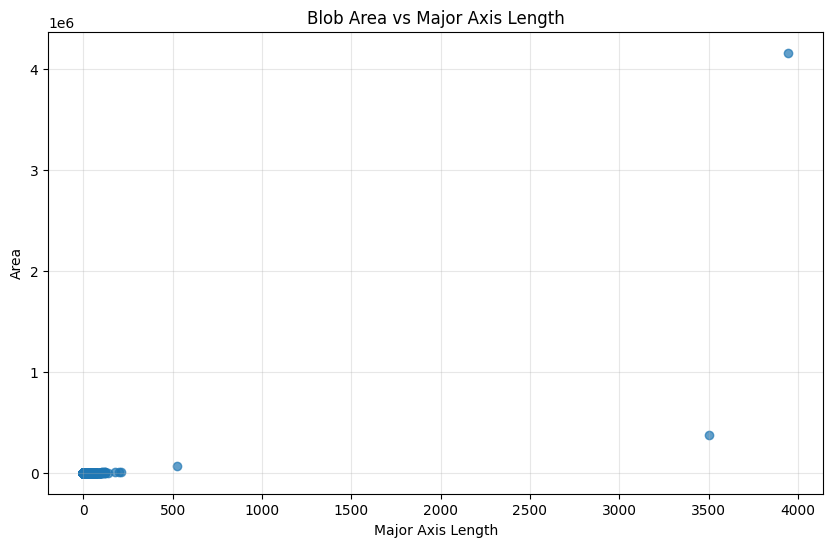

In [60]:
properties = ['label', 'area', 'eccentricity', 'extent', 'major_axis_length']
df = pd.DataFrame(measure.regionprops_table(labeled_img, properties=properties))

# Display properties
print("Regional properties of the blobs:")
print(df.head())

# Plot area vs major axis length
plt.figure(figsize=(10, 6))
plt.scatter(df['major_axis_length'], df['area'], alpha=0.7)
plt.xlabel('Major Axis Length')
plt.ylabel('Area')
plt.title('Blob Area vs Major Axis Length')
plt.grid(True, alpha=0.3)
plt.show()

##4. Analyze blobs
Since you have the feature data in a pandas dataframe, you can exploit all the functions of te libraries. For instance:

How many blobs have an area above the average?

In [61]:
avg_area = df['area'].mean()
print(f"Average blob area: {avg_area:.2f}")

# Identify blobs with area above average and below/equal to average
large_blobs = df[df['area'] > avg_area]
print(f"Number of blobs with area above average: {len(large_blobs)}")
large_blob_labels = large_blobs['label'].values

Average blob area: 936.22
Number of blobs with area above average: 32


Represent the blobs that have an area smaller than the average blob's area

In [62]:
small_blobs = df[df['area'] <= avg_area]
print(f"Number of blobs with area smaller than or equal to average: {len(small_blobs)}")
small_blob_labels = small_blobs['label'].values

Number of blobs with area smaller than or equal to average: 5046


find the labels of small and large blobs

In [63]:
print(f"Labels of large blobs: {large_blob_labels}")
print(f"Labels of small blobs: {small_blob_labels}")

Labels of large blobs: [   1    2   24  537  977 1270 1535 2392 2459 2481 2494 2797 2945 3043
 3159 3205 3246 3311 3482 3499 3781 3822 4017 4100 4156 4301 4328 4403
 4697 4758 4844 4892]
Labels of small blobs: [   3    4    5 ... 5076 5077 5078]


Create a binary mask with the large and small blobs

In [64]:
large_blob_mask = np.zeros_like(labeled_img, dtype=bool)
small_blob_mask = np.zeros_like(labeled_img, dtype=bool)

# Fill in the large blob mask
for label in large_blob_labels:
    large_blob_mask |= (labeled_img == label)

# Fill in the small blob mask
for label in small_blob_labels:
    small_blob_mask |= (labeled_img == label)

print("Binary masks created for large and small blobs")

Binary masks created for large and small blobs


Represent the large and small blobs

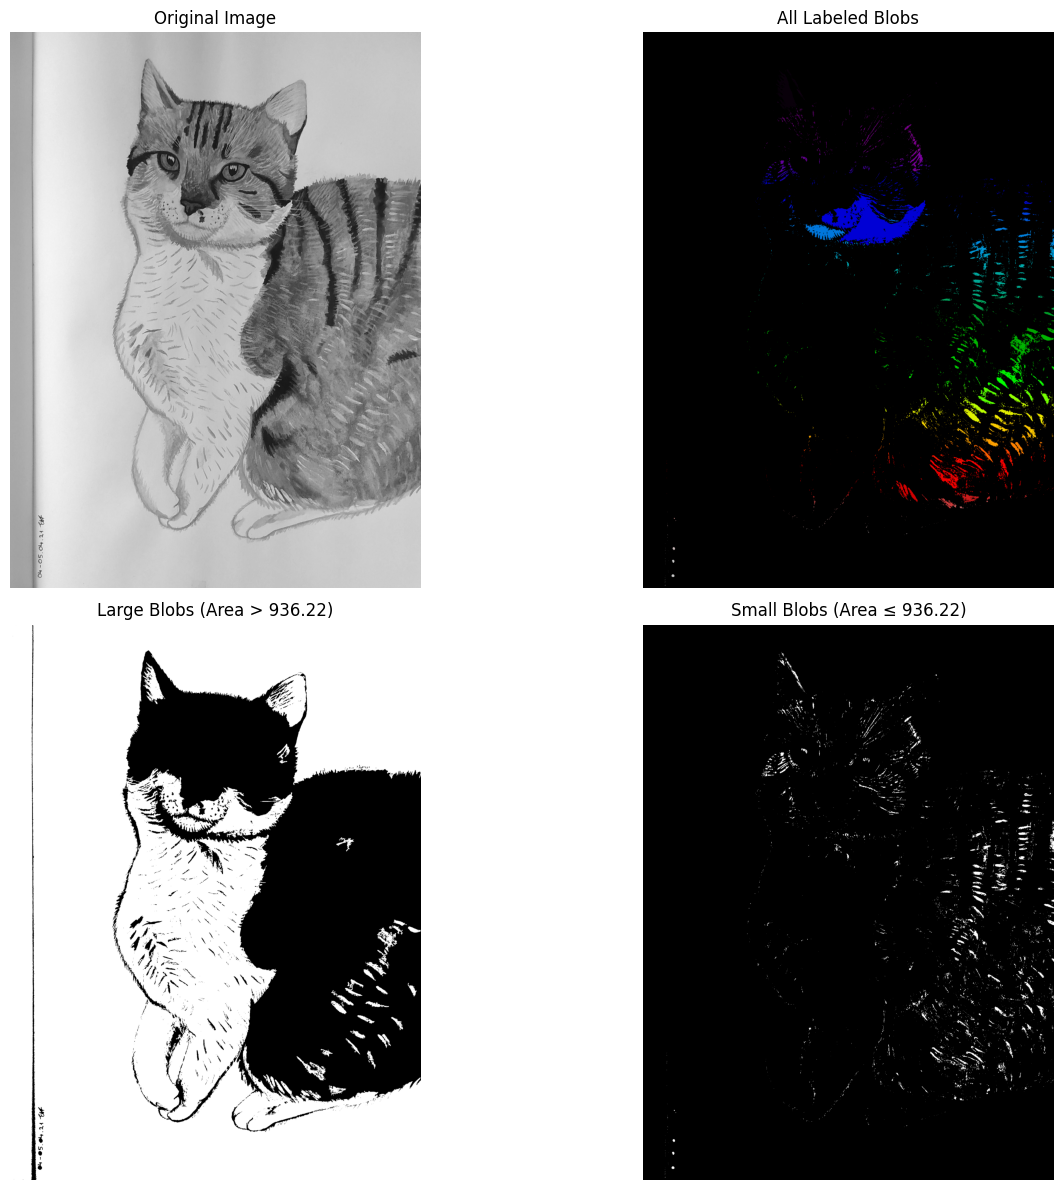

In [65]:
# Create a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Original image
axes[0, 0].imshow(img_gray, cmap='gray')
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

# All labeled blobs
axes[0, 1].imshow(labeled_img, cmap='nipy_spectral')
axes[0, 1].set_title('All Labeled Blobs')
axes[0, 1].axis('off')

# Large blobs
axes[1, 0].imshow(large_blob_mask, cmap='gray')
axes[1, 0].set_title(f'Large Blobs (Area > {avg_area:.2f})')
axes[1, 0].axis('off')

# Small blobs
axes[1, 1].imshow(small_blob_mask, cmap='gray')
axes[1, 1].set_title(f'Small Blobs (Area ≤ {avg_area:.2f})')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

##5. Obtain texture-based regional properties
For the original image

In [68]:
if img_gray.max() - img_gray.min() < 10:  # If the range is small
    gray_quantized = np.round((img_gray - gray_min) / (gray_max - gray_min) * 31).astype(np.uint8)
    levels = 32  # Use fewer levels for better GLCM statistics
else:
    # Regular quantization, but ensure proper uint8 conversion
    gray_quantized = img_gray.astype(np.uint8) if img_gray.max() <= 1 else img_gray
    levels = 32  # Still using fewer levels than 256 for better statistics

# Calculate GLCM properties with multiple angles for better texture representation
texture_features = []
for region in measure.regionprops(labeled_img):
    minr, minc, maxr, maxc = region.bbox
    roi = gray_quantized[minr:maxr, minc:maxc]

    # Skip tiny regions
    if roi.shape[0] <= 1 or roi.shape[1] <= 1:
        texture_features.append({
            'label': region.label,
            'contrast': 0,
            'dissimilarity': 0,
            'homogeneity': 1,
            'energy': 1,
            'correlation': 0
        })
        continue

    # Check if region is uniform (all same value)
    if np.all(roi == roi[0, 0]):
        texture_features.append({
            'label': region.label,
            'contrast': 0,
            'dissimilarity': 0,
            'homogeneity': 1,
            'energy': 1,
            'correlation': 0
        })
        continue

    # Use multiple angles for better texture representation
    distances = [1]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

    try:
        # Calculate GLCM with fewer gray levels (e.g., 32 instead of 256)
        glcm = feature.graycomatrix(roi, distances, angles,
                                    levels=levels,
                                    symmetric=True,
                                    normed=True)

        # Calculate all properties and average across all angles
        contrast = feature.graycoprops(glcm, 'contrast').mean()
        dissimilarity = feature.graycoprops(glcm, 'dissimilarity').mean()
        homogeneity = feature.graycoprops(glcm, 'homogeneity').mean()
        energy = feature.graycoprops(glcm, 'energy').mean()
        correlation = feature.graycoprops(glcm, 'correlation').mean()

        texture_features.append({
            'label': region.label,
            'contrast': contrast,
            'dissimilarity': dissimilarity,
            'homogeneity': homogeneity,
            'energy': energy,
            'correlation': correlation
        })
    except Exception as e:
        # Provide default values on error
        texture_features.append({
            'label': region.label,
            'contrast': 0,
            'dissimilarity': 0,
            'homogeneity': 1,
            'energy': 1,
            'correlation': 0
        })

# Create dataframe with only required columns
texture_df = pd.DataFrame(texture_features)

# Create dataframe with shape features, selecting only the columns we want
shape_df = pd.DataFrame({
    'label': [region.label for region in measure.regionprops(labeled_img)],
    'area': [region.area for region in measure.regionprops(labeled_img)],
    'eccentricity': [region.eccentricity for region in measure.regionprops(labeled_img)],
    'extent': [region.extent for region in measure.regionprops(labeled_img)],
    'major_axis_length': [region.major_axis_length for region in measure.regionprops(labeled_img)]
})

# Merge the shape and texture dataframes
merged_df = pd.merge(shape_df, texture_df, on='label')

print("\nCombined shape and texture properties:")
print(merged_df.head())


Combined shape and texture properties:
   label       area  eccentricity    extent  major_axis_length  contrast  \
0      1   371043.0      0.999190  0.975466        3502.316416  0.171012   
1      2  4161190.0      0.797439  0.643209        3944.145774  0.670359   
2      3        4.0      0.790569  0.666667           2.828427  0.270833   
3      4        3.0      0.816497  0.750000           2.309401  0.500000   
4      5       92.0      0.899221  0.393162          19.929357  0.495637   

   dissimilarity  homogeneity    energy  correlation  
0       0.113926     0.948280  0.587244     0.891496  
1       0.370276     0.841039  0.245759     0.990606  
2       0.270833     0.864583  0.772508     0.080952  
3       0.500000     0.750000  0.732963    -0.166667  
4       0.421207     0.796666  0.426078     0.725349  
